# Preliminary Analysis

Initial analysis of offline evaluation experimentation on baseline recommender systems.

### Setup

Import libraries.

In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import pandas as pd

### Load evaluation results

Experiment components:

1. True preference data generator (nuser 943, nitem 1682, density 0.5):
    - Indian Buffet Process
    - Uniform generator
    
2. Observation sampler:
    - Popular sampler
    - Uniform sampler
    
3. Evaluation Protocal:
    - Partition by user on user-item dense matrix, sample 0.2 items for test per user.
    
4. Recommenders
    - Popular
    - Random
    - Oracle

Evaluation results come from the combination of all the components.

In [2]:
with open('build/ibp-unif-eval-results.pickle', 'rb') as f:
    ibp_unif = pkl.load(f)

In [3]:
with open('build/ibp_pop-eval-results.pickle', 'rb') as f:
    ibp_pop = pkl.load(f)

In [4]:
with open('build/unif_unif-eval-results.pickle', 'rb') as f:
    unif_unif = pkl.load(f)

In [5]:
with open('build/unif_pop-eval-results.pickle', 'rb') as f:
    unif_pop = pkl.load(f)

### Plot the results

In [6]:
def extract_result(sims_results, metric='precision'):
    obs_label = ''.join([metric, '_obs'])
    pref_label = ''.join([metric, '_pref'])
    result = sims_results[['algorithm', obs_label, pref_label]]
    result = result.rename(columns={obs_label: 'observation', pref_label: 'preference'})
    result['error'] = result['observation'] - result['preference']
    return result

In [7]:
def plot_vertical_mean(a, **kwargs):
    x = a.mean()
    plt.axvline(x)
    bottom, top = plt.ylim()
    xid = round(x+0.0002, 4)
    yid = round(top*0.8)
    text = "mean={:.2f}".format(x)
    plt.text(xid, yid, text, rotation=90)

In [8]:
def plot_metric(sims_results, metric='precision', style='seaborn-talk'):
    with plt.style.context(style):
        res = extract_result(sims_results, metric)
        res_tall = res.melt(id_vars='algorithm', var_name='type', value_name='metric')
        g = sns.FacetGrid(res_tall, col='algorithm', row='type', 
                          sharey=False, sharex=False, height=5,
                          margin_titles=True)
        g = g.map(sns.distplot, 'metric')
        g = (g.map(plot_vertical_mean, 'metric')
             .set_titles(col_template='{col_name}')
             .set_axis_labels(metric, 'count'))
    plt.show()

### IBP - Uniform

This model configuration emphasizes popularity effect. 

**Precision**

/home/mtian/anaconda3/envs/lkpy/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


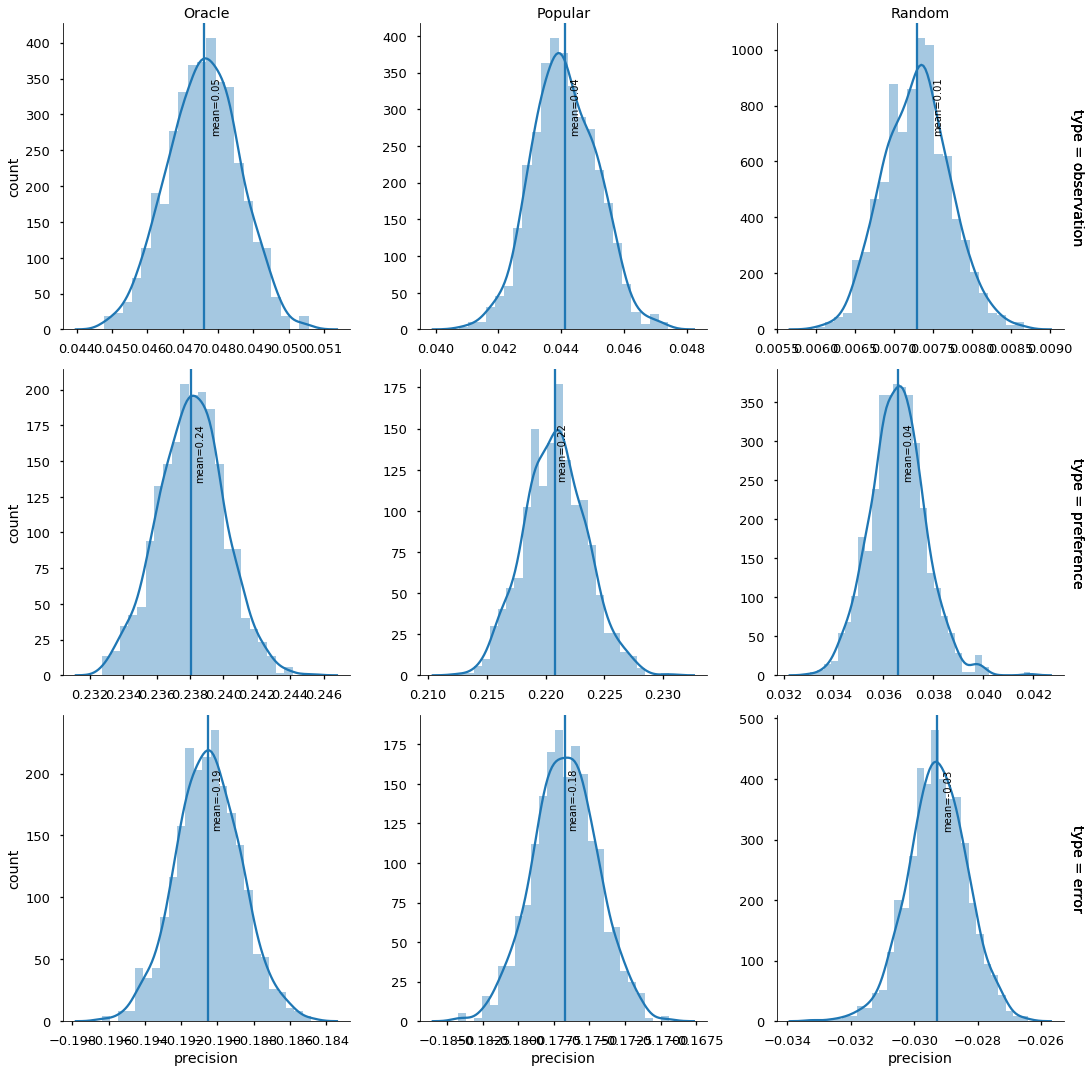

In [9]:
plot_metric(ibp_unif, 'precision')

- Precision performs better on true preferences than on observations. This may be because our experiment assumes that relevant items are missing, and precision doesn't change the length of recommendation lists. This cause the number of relevant items using true preferences are always greater than or equal to the one using observations.

- This doesn't change the ranking order of recommendation algorithms. Popular recommender is close to the Oracle recommender and much better than random recommender.

**Recall**

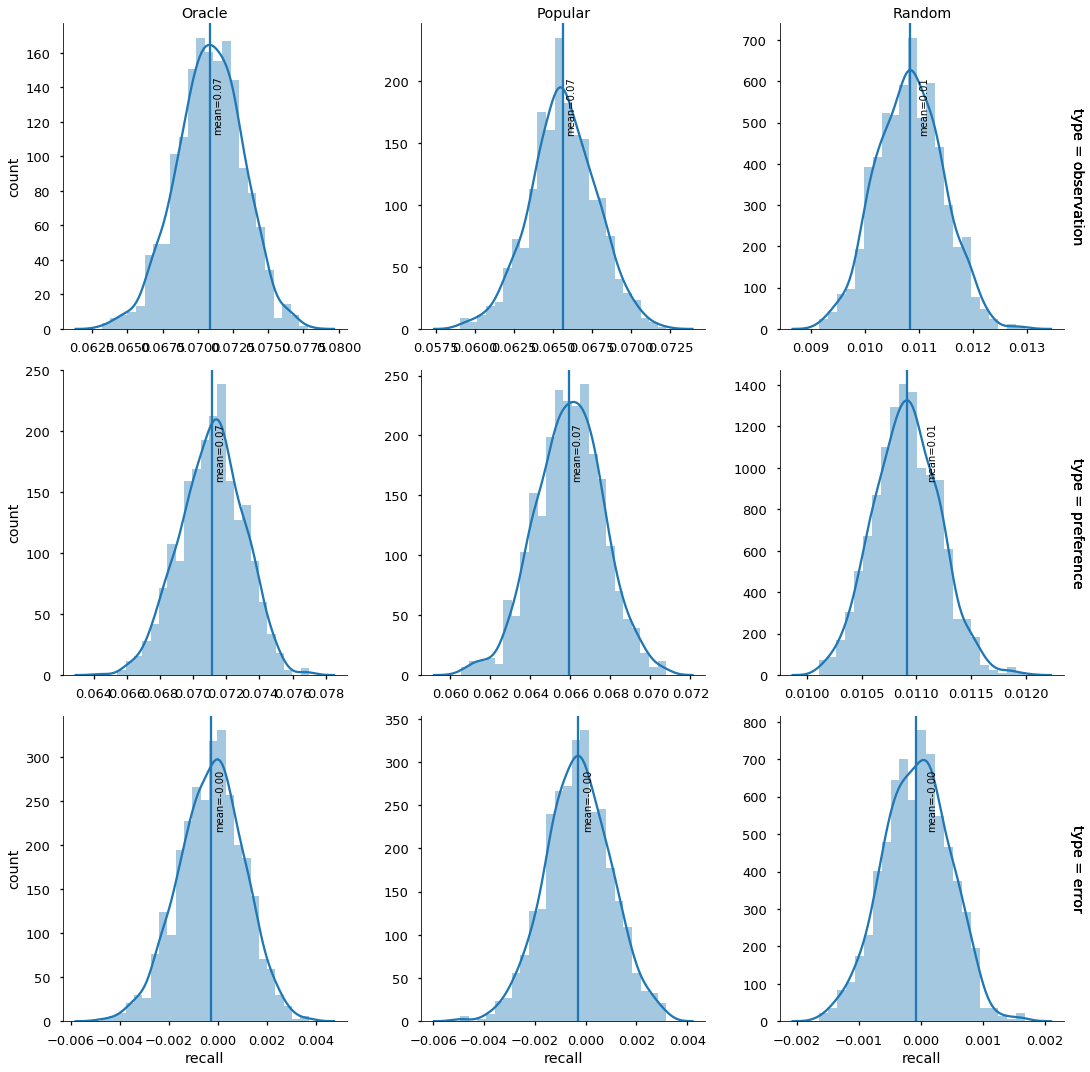

In [10]:
plot_metric(ibp_unif, 'recall')

- Recall well satisfied Steck's paper conlusion!

- Popular recommender reaches the Oracle recommender performance!

**Reciprocal Rank**

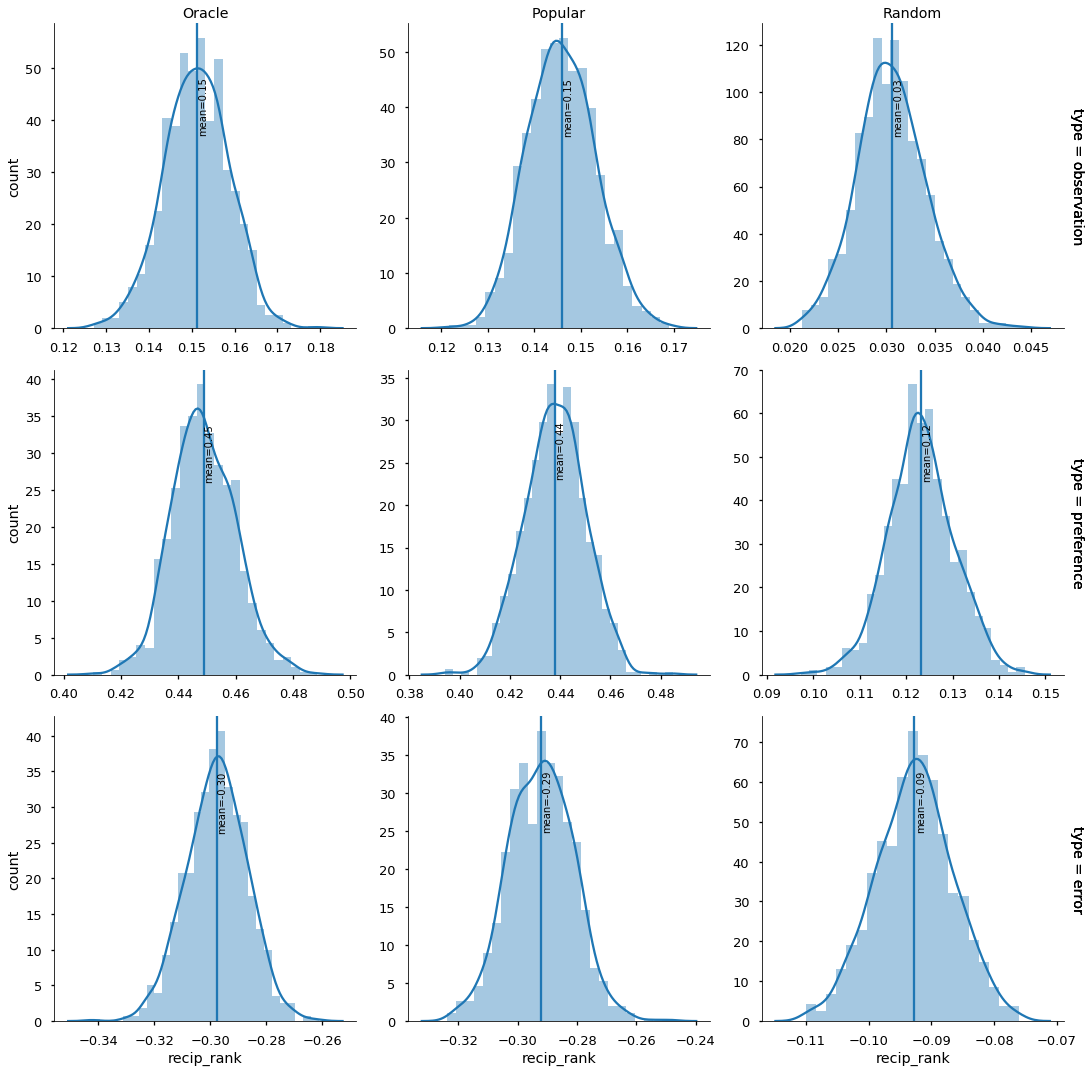

In [11]:
plot_metric(ibp_unif, 'recip_rank')

- Simular results to previous ones
- Biased metric

**nDCG**

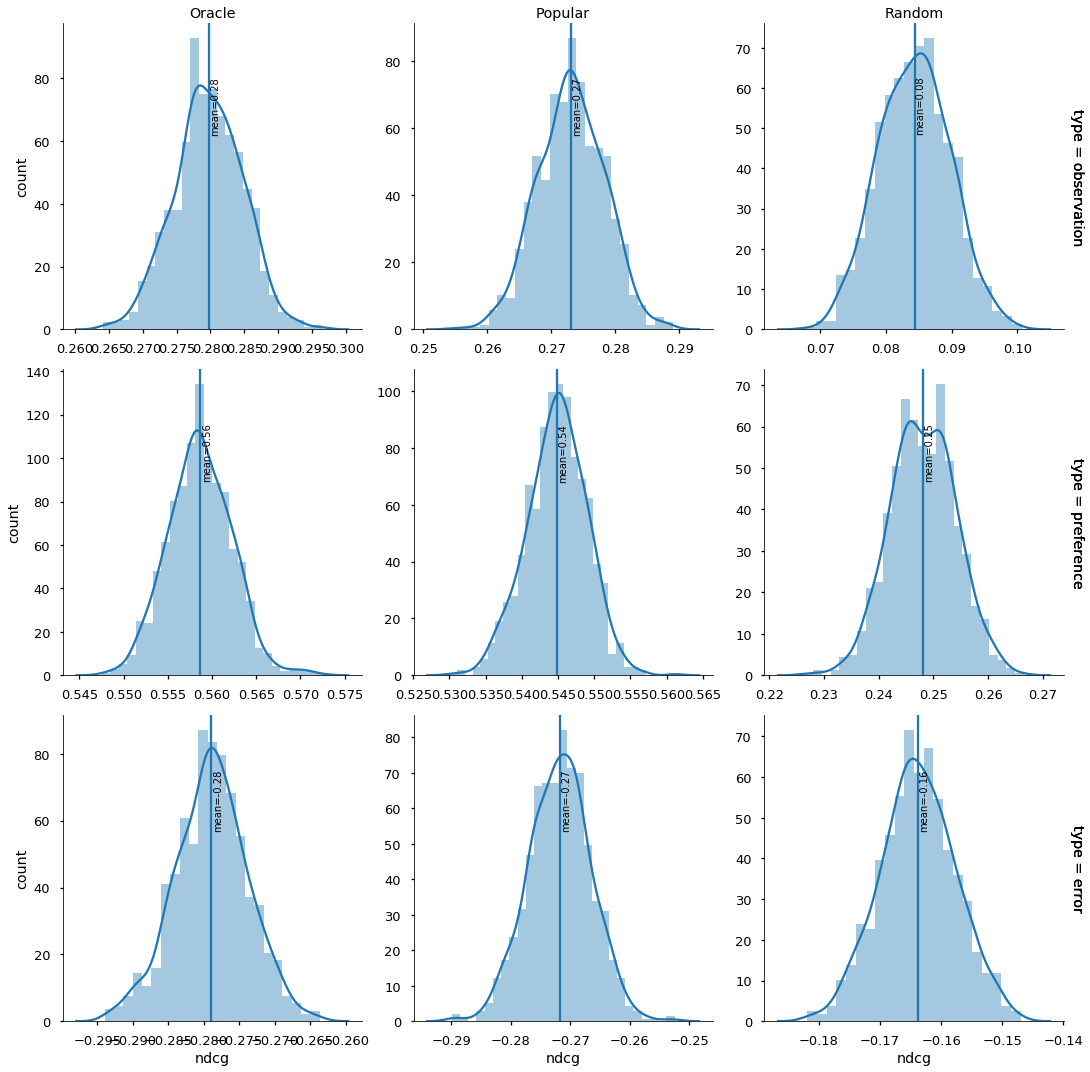

In [12]:
plot_metric(ibp_unif, 'ndcg')

- Similar results.
- Baised metric.

### IBP - Popularity

This model emphasizes popularity even more than first one.

**Precision**

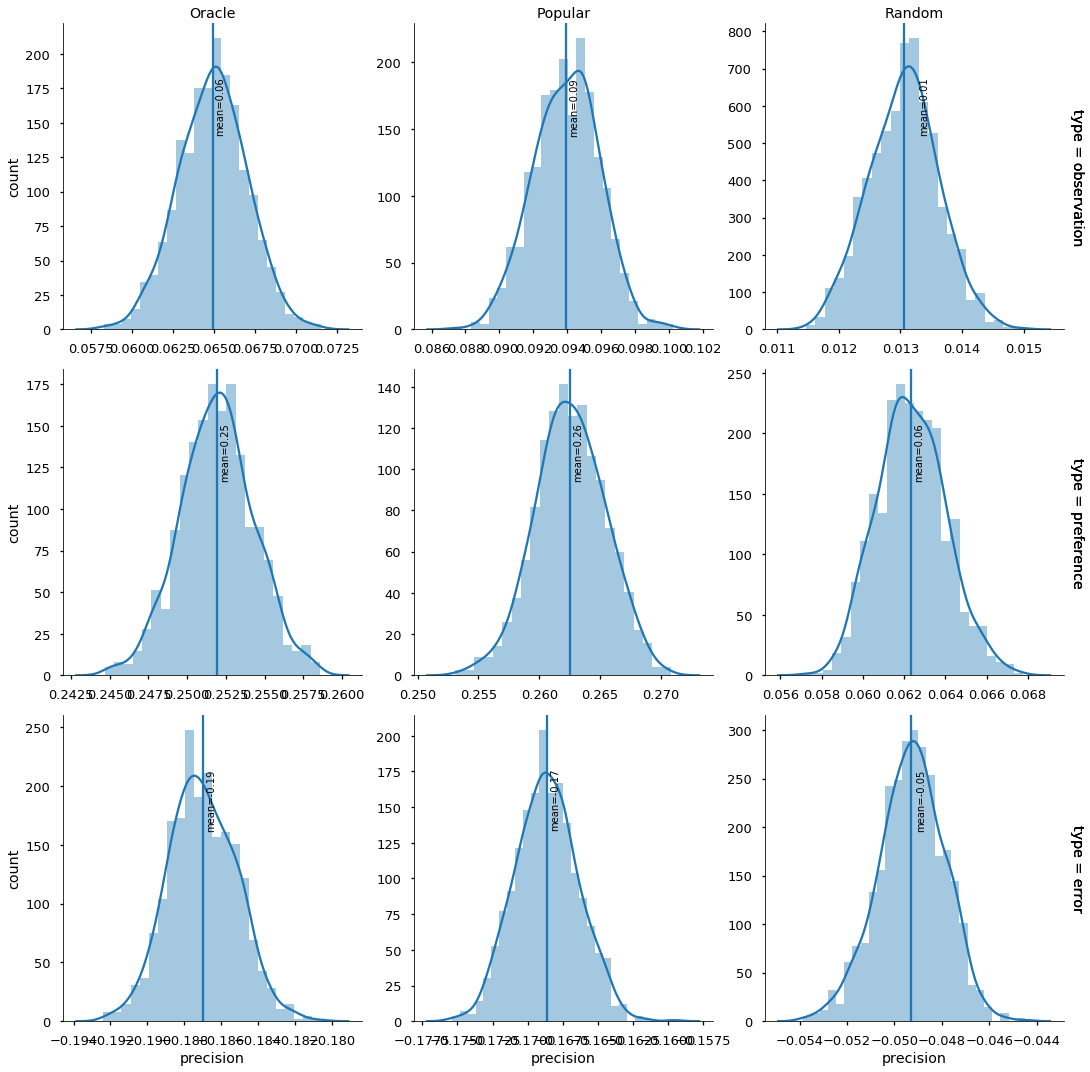

In [13]:
plot_metric(ibp_pop, 'precision')

- Popular recommender even outperforms the Oracle recommender!

**Recall**

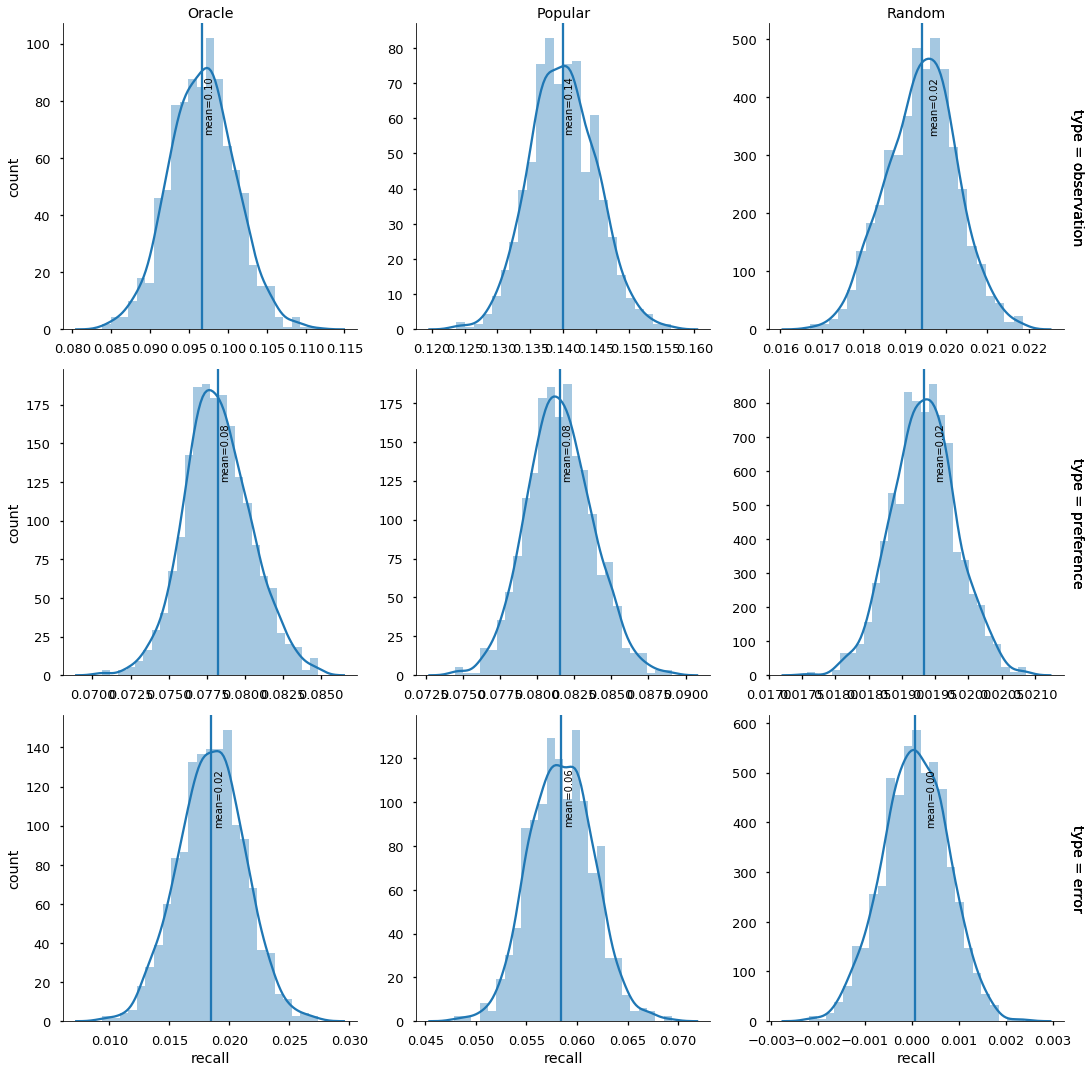

In [14]:
plot_metric(ibp_pop, 'recall')

- Popular recommender outperforms the Oracle on observations but is comparable to the Oracle on true preferences.

**Reciprocal Rank**

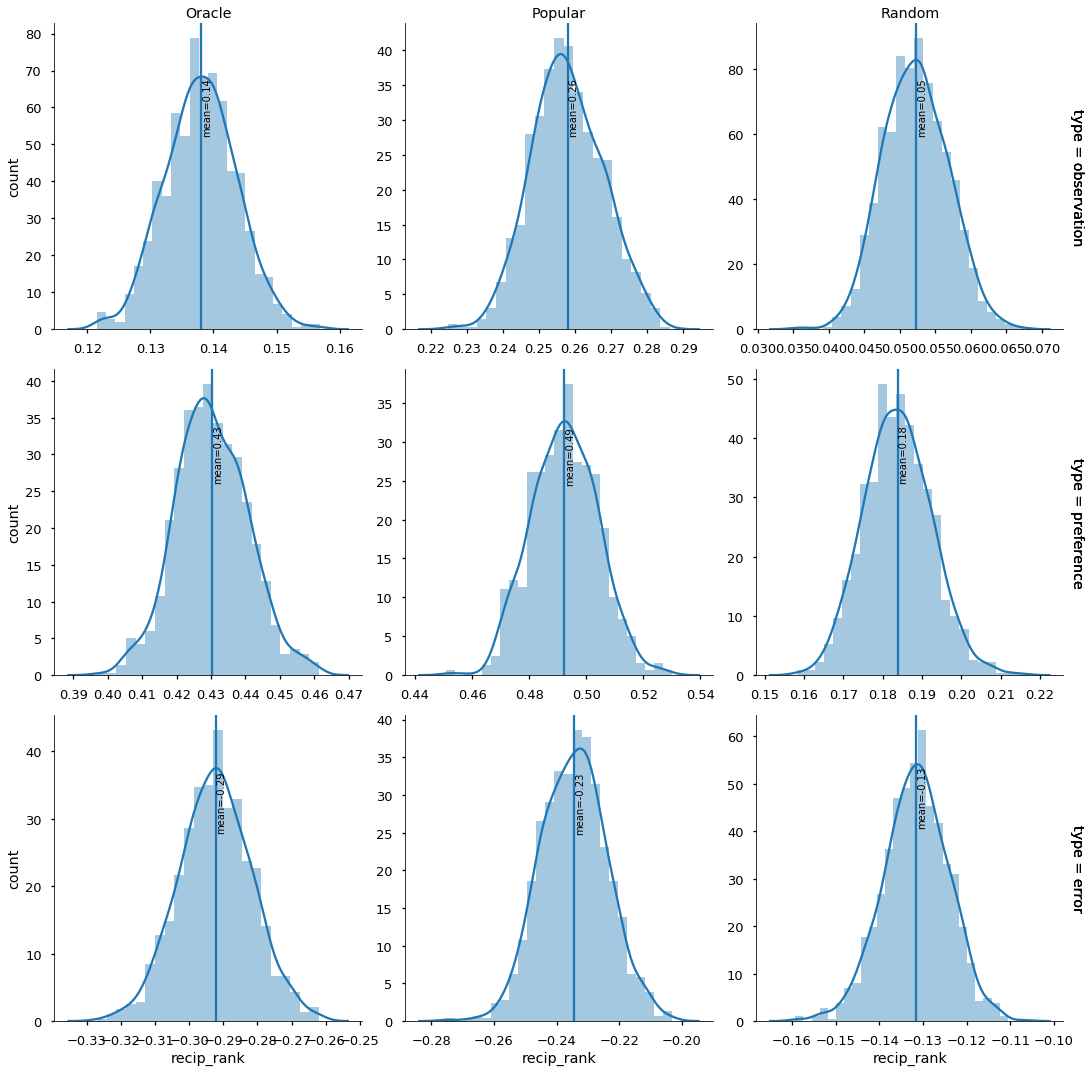

In [15]:
plot_metric(ibp_pop, 'recip_rank')

- Popular works the best among all the three recommders on both observations and true preferences.

**nDCG**

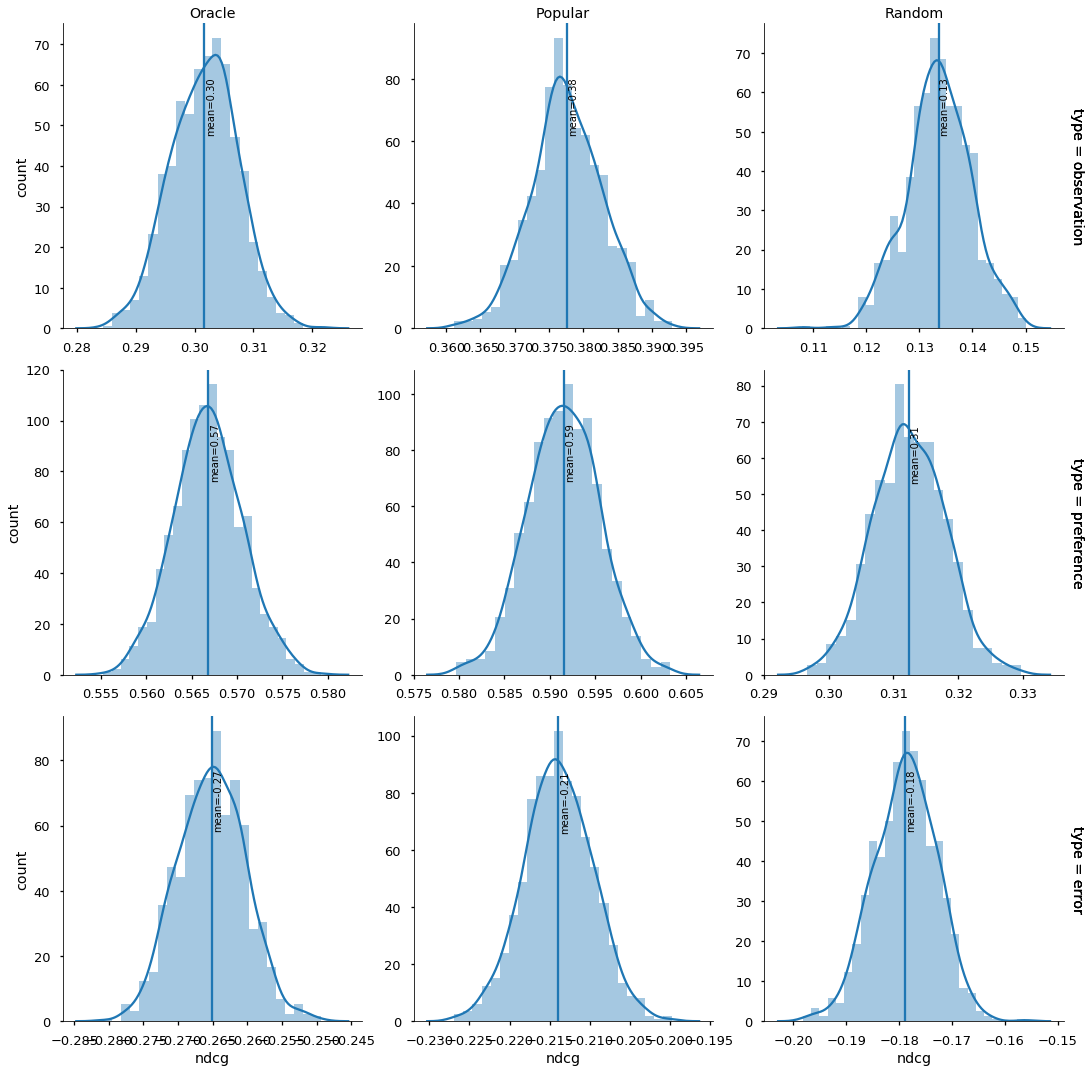

In [16]:
plot_metric(ibp_pop, 'ndcg')

- Similar to previous one.

### Uniform - Uniform

This model reduces the popularity effect.

**Precision**

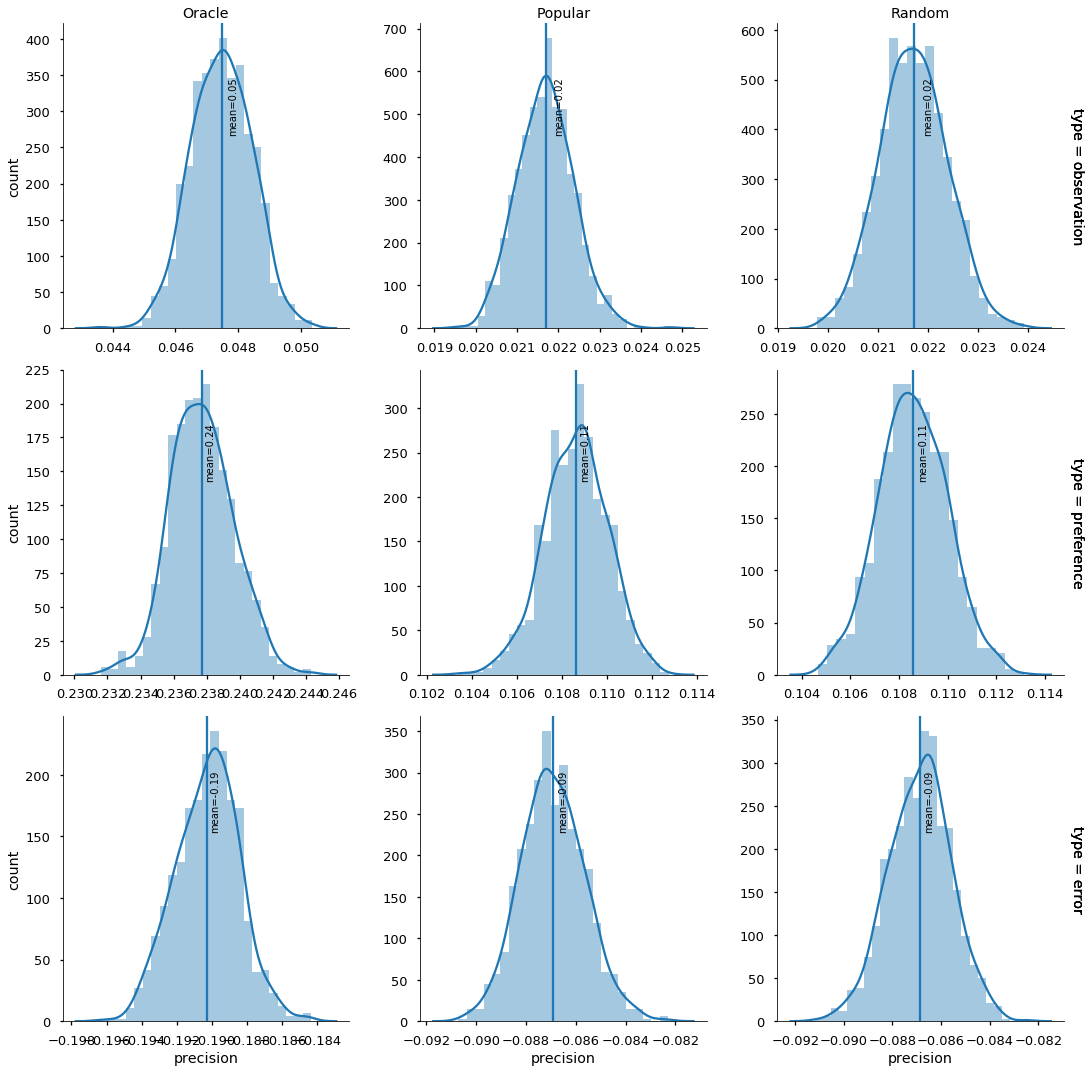

In [17]:
plot_metric(unif_unif, 'precision')

- Popular recommender can't even beat the random recommender!

**Recall**

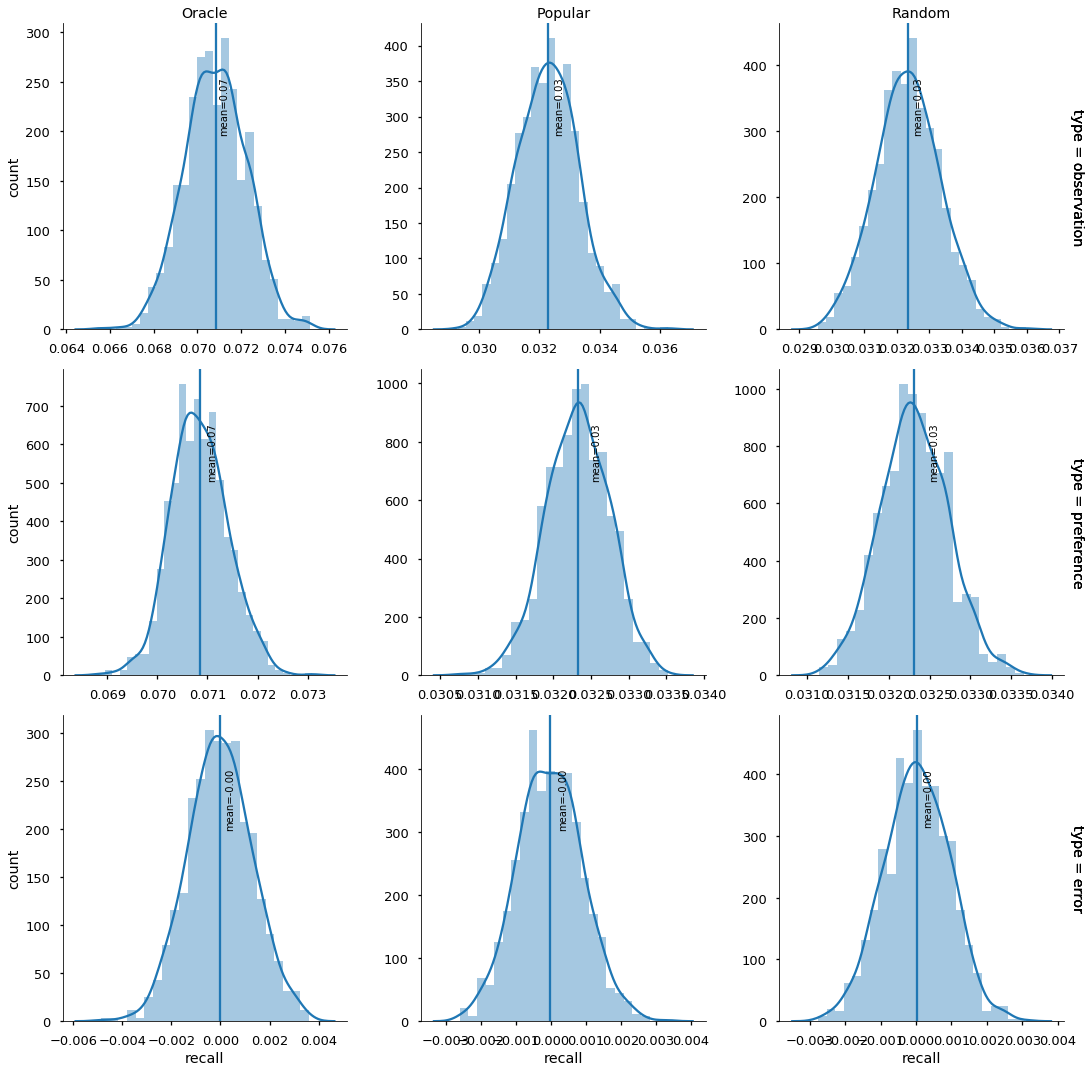

In [18]:
plot_metric(unif_unif, 'recall')

- Recall is unbiased.

**Reciprocal Rank**

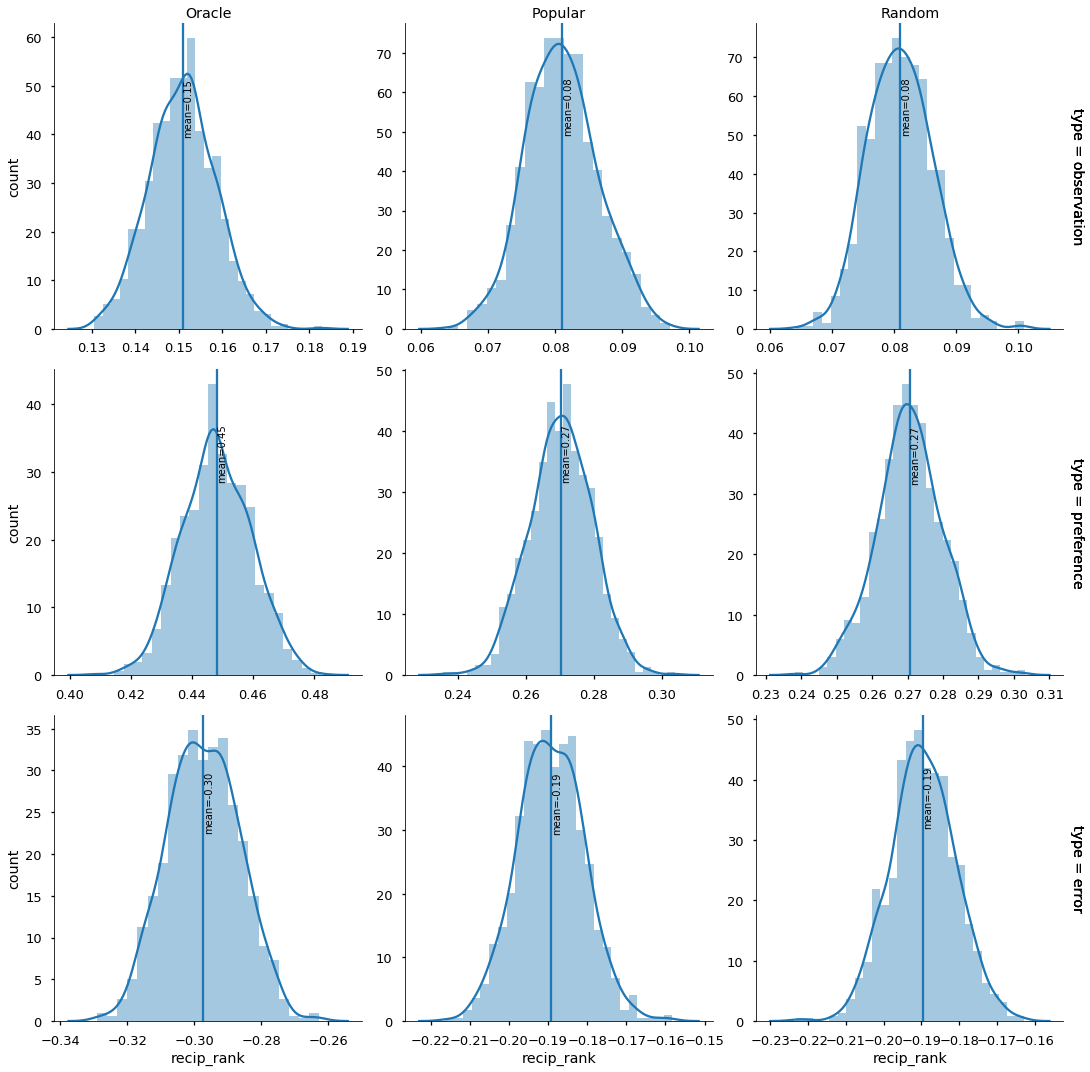

In [19]:
plot_metric(unif_unif, 'recip_rank')

**nDCG**

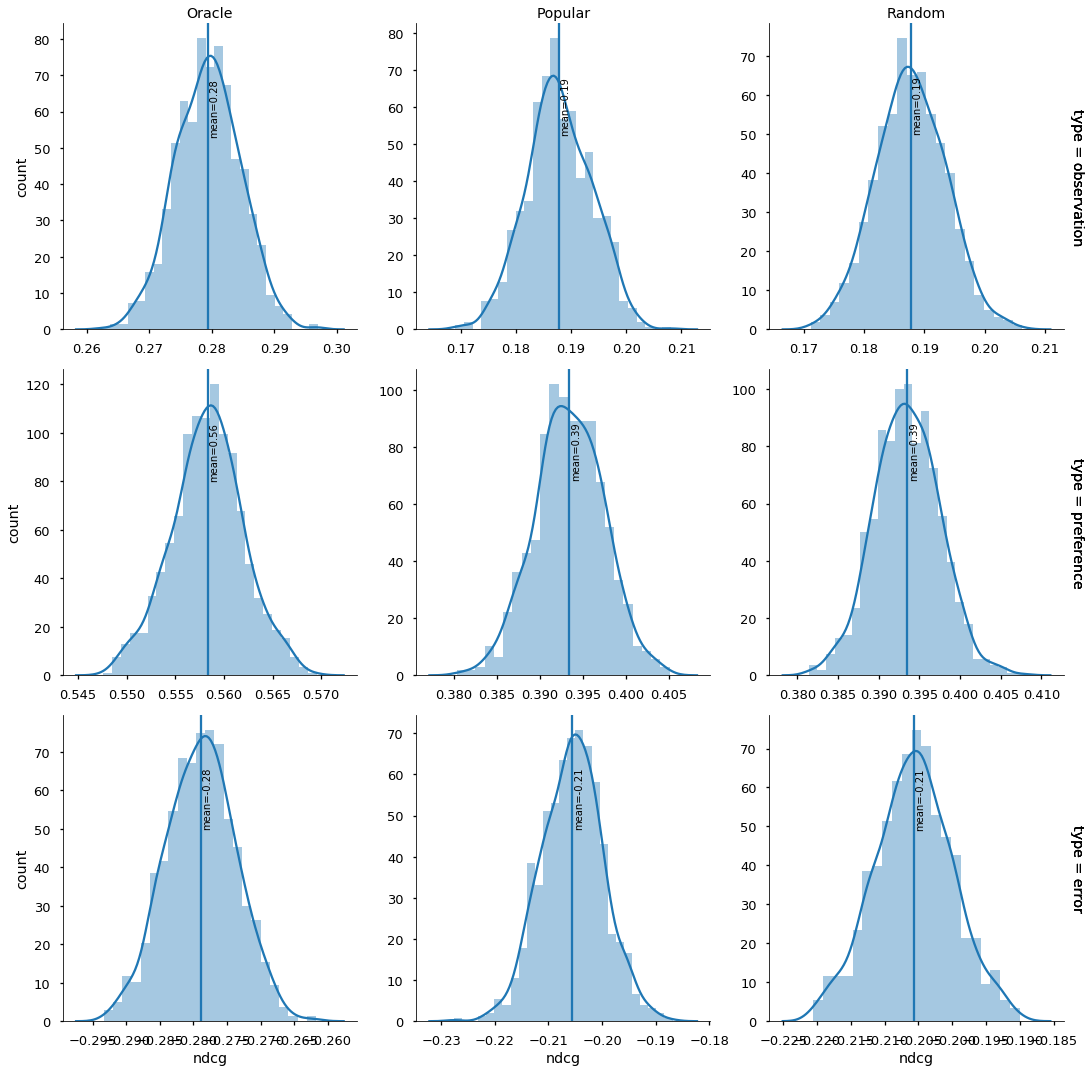

In [20]:
plot_metric(unif_unif, 'ndcg')

- In this configuration, the Popular recommender is totally reduced to a random recommender and performs very similar to a random recommender in terms of all the data generations and metrics.

### Uniform - Popularity

- Since each item has an euqal probability (item A and B are exchangeable of being generated as relevant item) of being generated as an user's true preference, there might be little popularity effect even using popularity sampling. It means every item can be a popular item, then popular sampling will look like random sampling, also for popular recommender. But the popularity sampling is based on generated data, then given a generated data, the frequency of some items can still be greater others. Thus for a given user size, the popularity sampling will still cause that some items become more dominant than others.
- Popularity sampling makes the relevant items not missing at random.
- Popular recommender is almostly reduced to a random recommender.

**Precision**

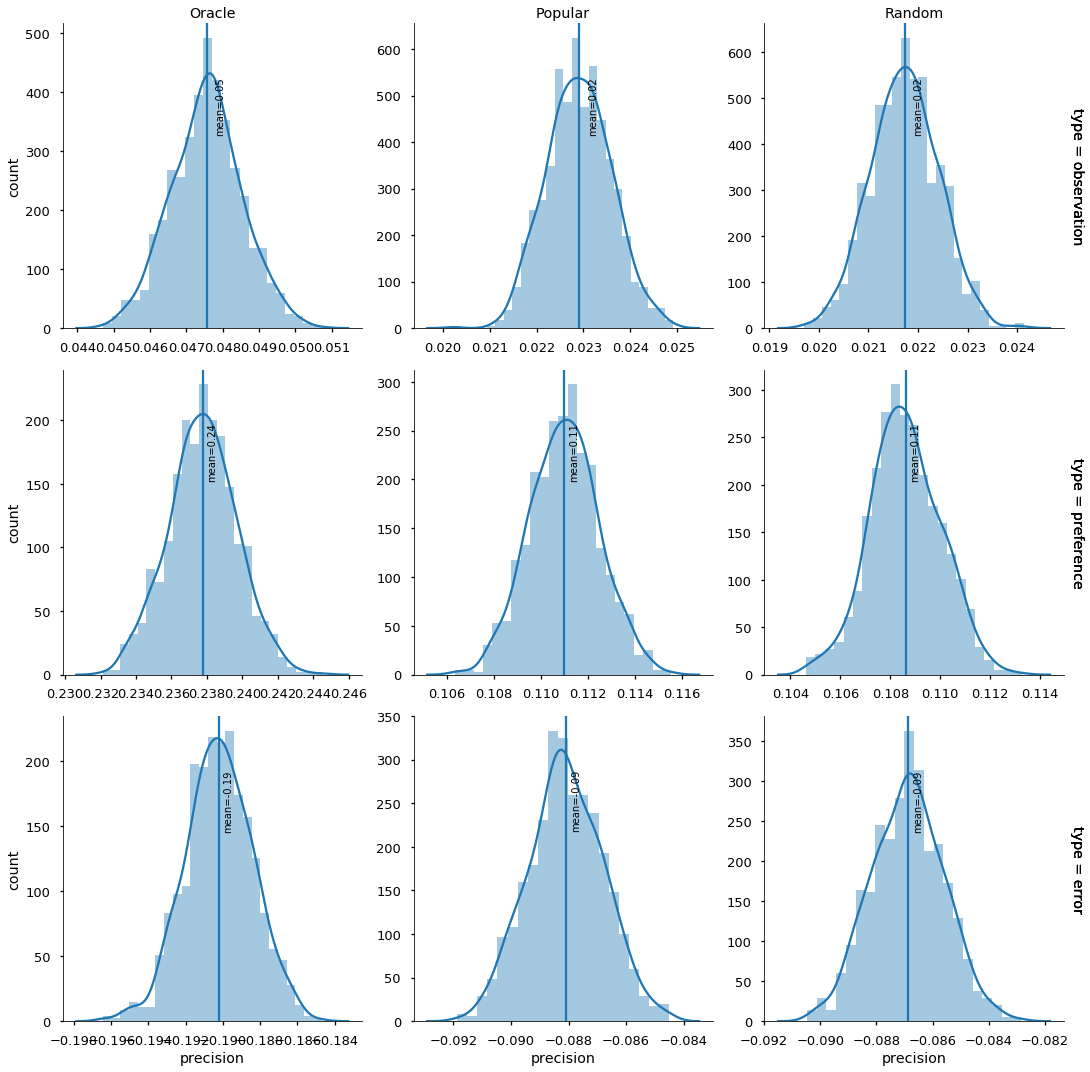

In [21]:
plot_metric(unif_pop, 'precision')

**Recall**

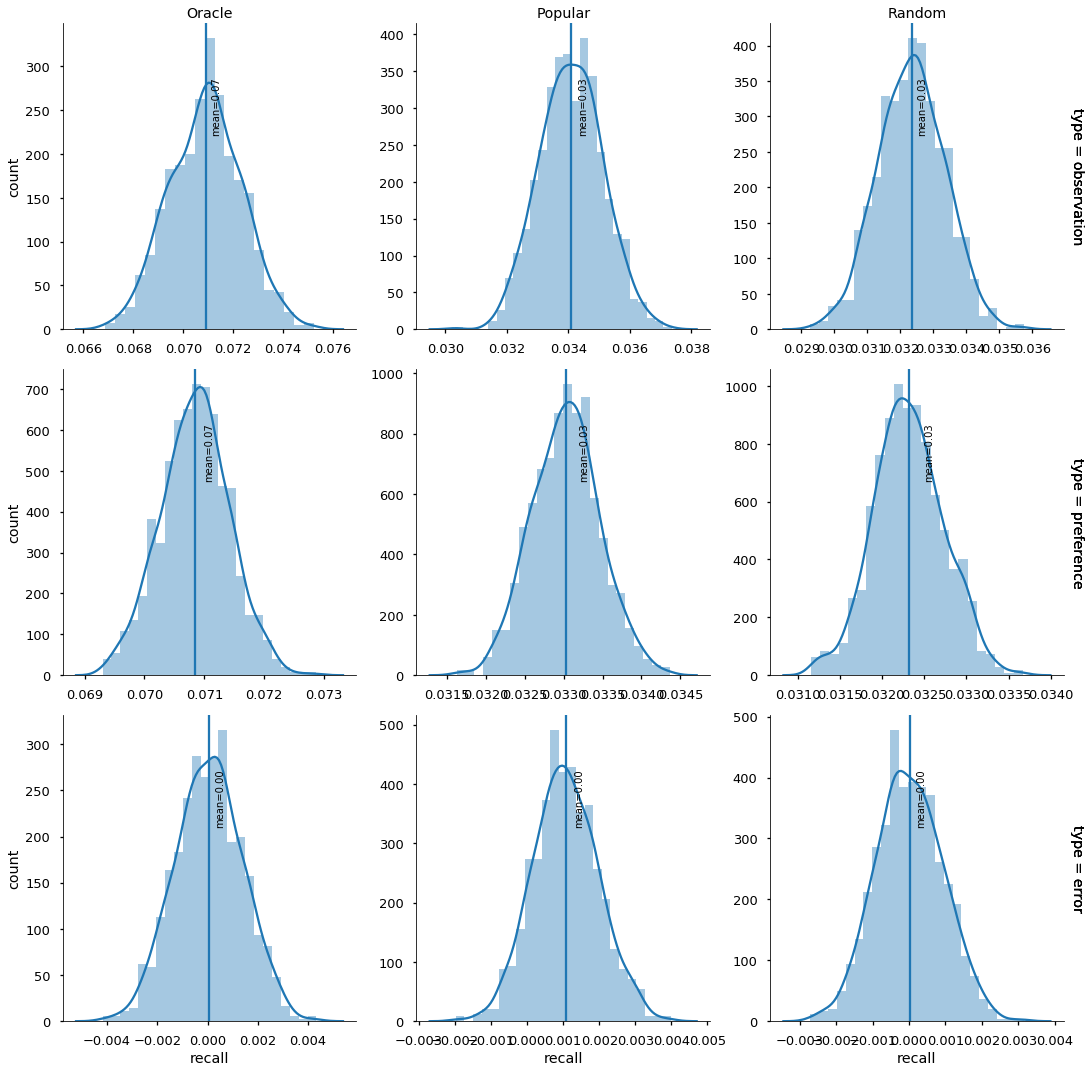

In [22]:
plot_metric(unif_pop, 'recall')

**Reciprocal Rank**

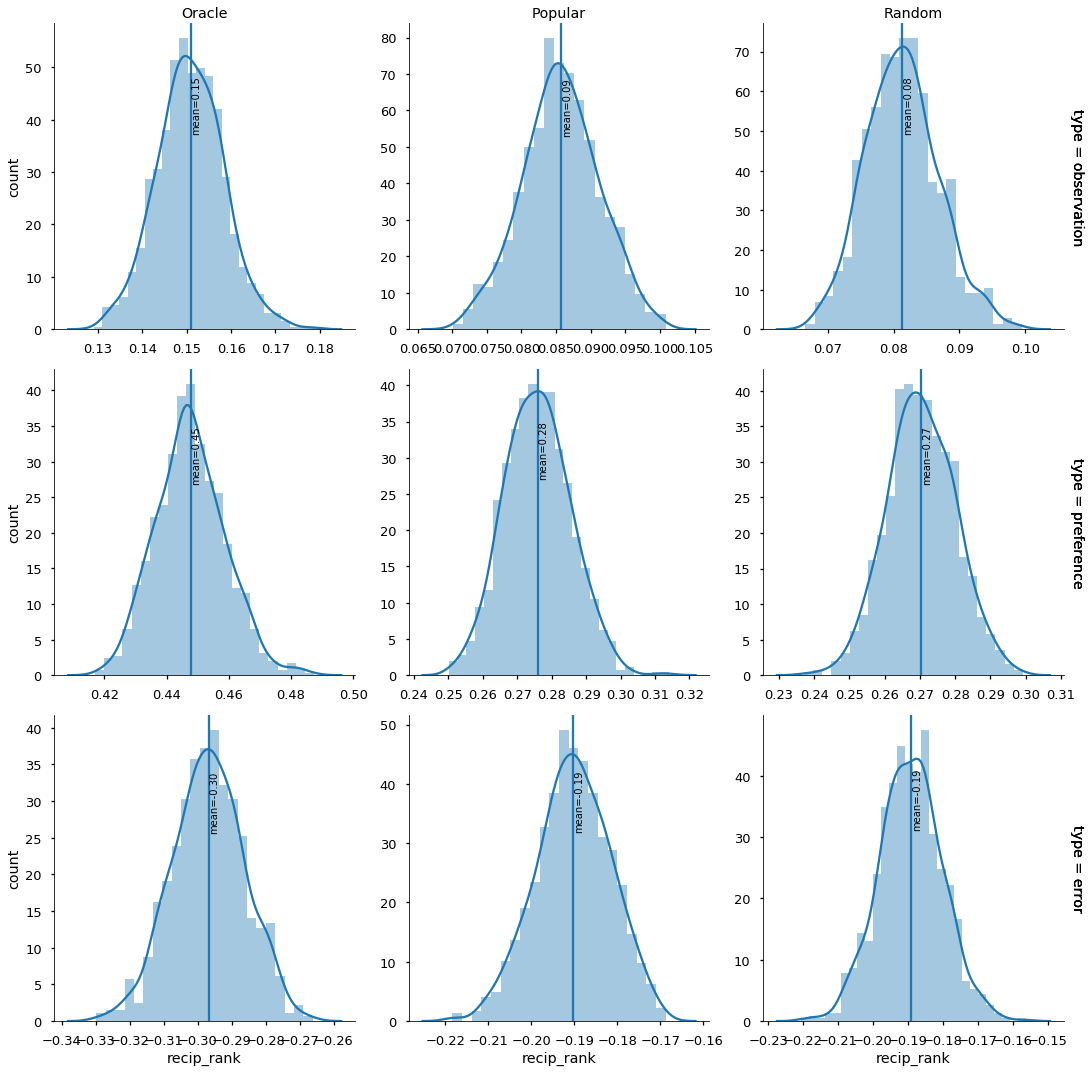

In [23]:
plot_metric(unif_pop, 'recip_rank')

**nDCG**

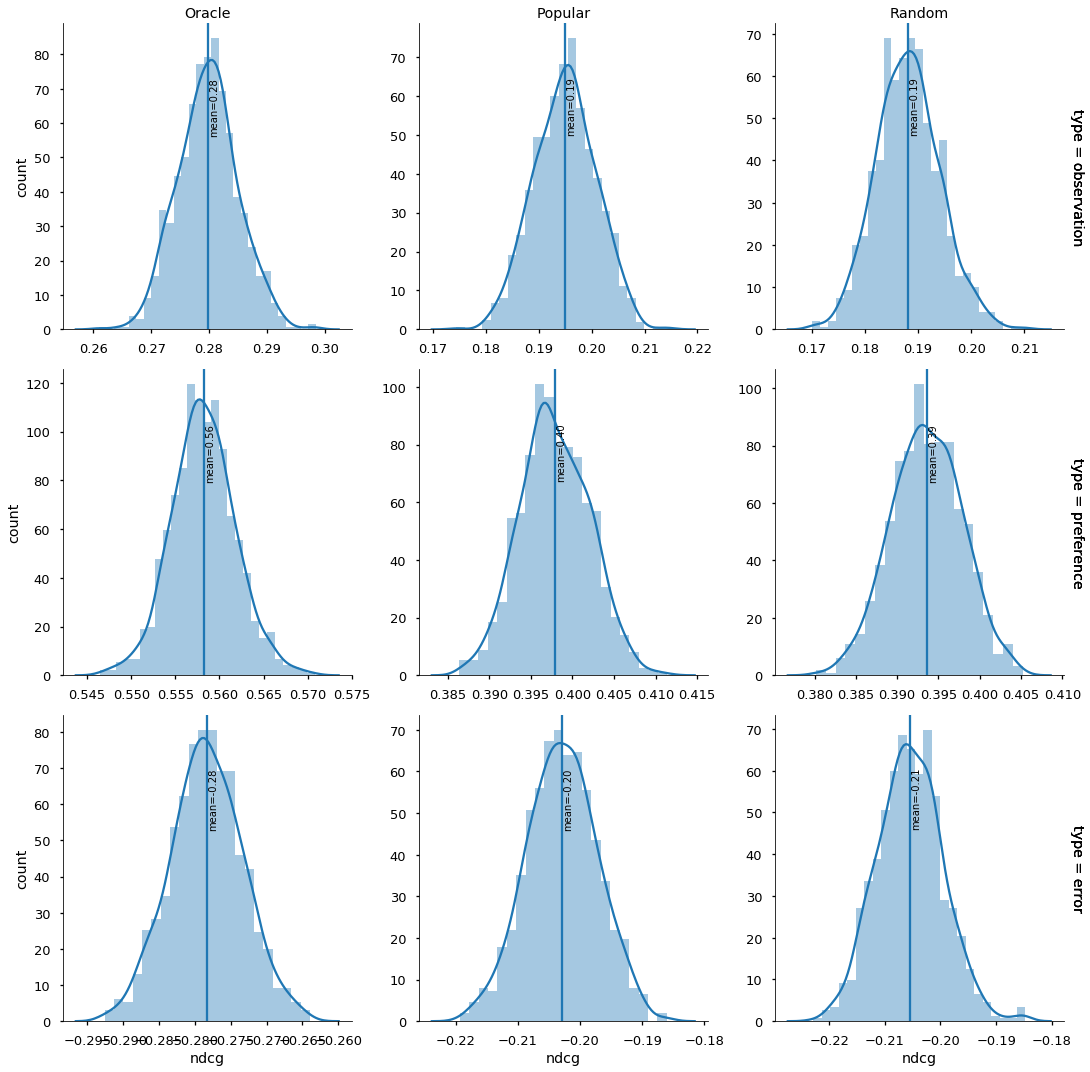

In [24]:
plot_metric(unif_pop, 'ndcg')

### Boxplot and Bar Chart

Combine data

In [25]:
def combine_data(datasets, generator_names, sampler_names, metric):
    data_list = map(lambda d, g, s: 
                    extract_result(d, metric).assign(generator=g, sampler=s), 
                    datasets, generator_names, sampler_names)
    return pd.concat(data_list, axis=0, ignore_index=True)

In [26]:
def plot_metric_stats(data, metric, metric_on, plot_func, style='seaborn-talk', **kwargs):
    df = data[['algorithm', 'generator', 'sampler', metric_on]]
    with plt.style.context(style):
        g = sns.FacetGrid(df, row='generator', col='sampler', 
                          sharey=False, sharex=True, 
                          height=5, margin_titles=True)
        g = (g.map(plot_func, 'algorithm', metric_on, **kwargs)
             .set_ylabels('-'.join([metric, metric_on])))
    plt.show()

In [27]:
def plot_metric_stats_dtype(data, metric, plot_func, style='seaborn-poster', **kwargs):
    df = data[['algorithm', 'generator', 'sampler', 'observation', 'preference']]
    df_tall = df.melt(id_vars=['algorithm', 'generator', 'sampler'], 
                      var_name='dtype', value_name='metric')
    with plt.style.context(style):
        g = sns.FacetGrid(df_tall, row='generator', col='sampler', 
                          sharey=False, sharex=True, 
                          height=5, margin_titles=True, 
                          legend_out=True)
        g = (g.map(plot_func, 'algorithm', 'metric', 'dtype', **kwargs)
             .add_legend()
             .set_ylabels(metric))
    plt.show()

In [28]:
sims_results = [ibp_unif, ibp_pop, unif_unif, unif_pop]
g_names = ['ibp', 'ibp', 'uniform', 'uniform']
s_names = ['uniform', 'popularity', 'uniform', 'popularity']

**Precision**

In [29]:
data2plot = combine_data(sims_results, g_names, s_names, 'precision')

In [30]:
data2plot.head()

,algorithm,observation,preference,error,generator,sampler
0,Oracle,0.045642,0.236267,-0.190626,ibp,uniform
1,Popular,0.044793,0.219364,-0.174571,ibp,uniform
2,Random,0.008081,0.038134,-0.030053,ibp,uniform
3,Oracle,0.047466,0.238155,-0.190689,ibp,uniform
4,Popular,0.043245,0.220255,-0.177010,ibp,uniform


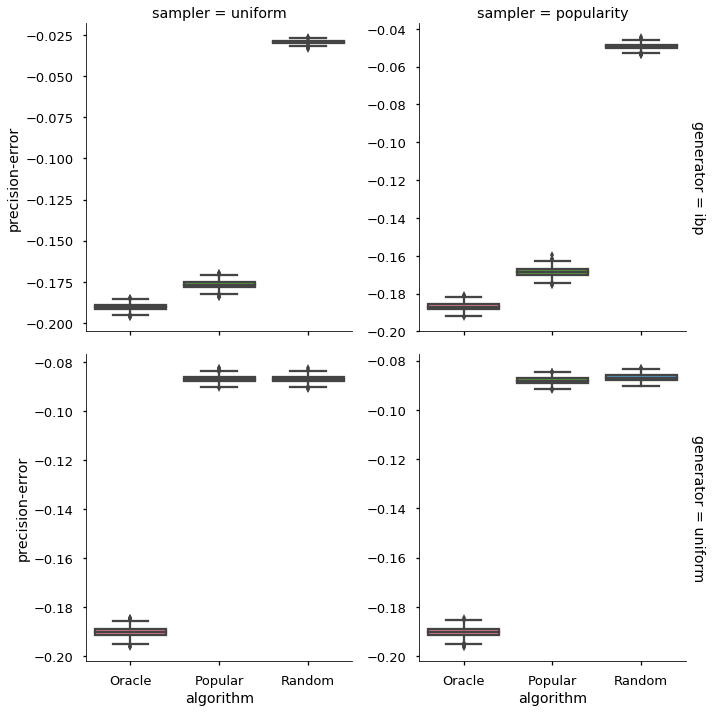

In [31]:
plot_metric_stats(data2plot, 'precision', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'], 
                  palette='husl')

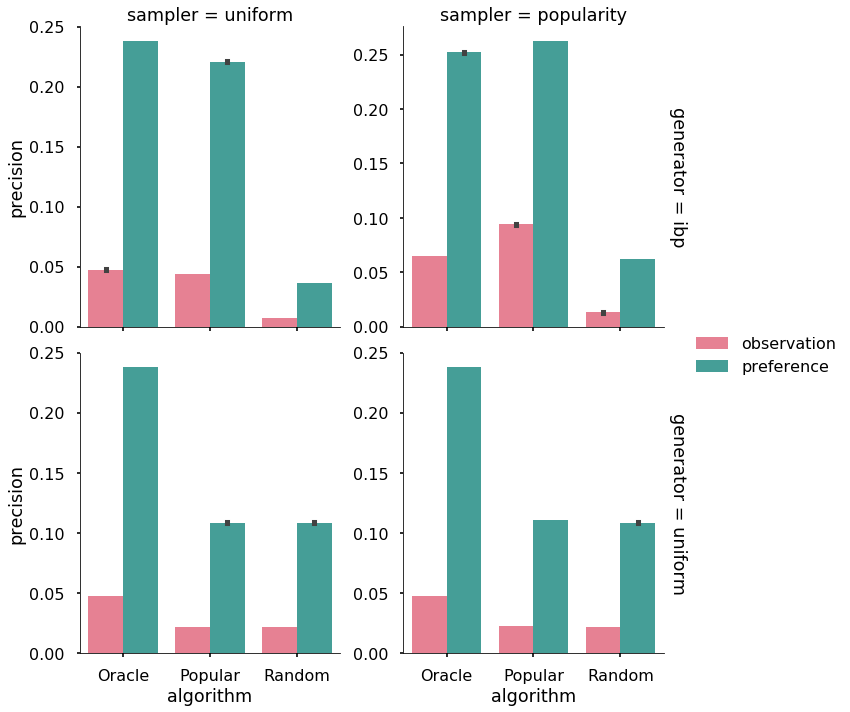

In [32]:
plot_metric_stats_dtype(data2plot, 'precision', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=['observation', 'preference'],
                        palette='husl')

**Recall**

In [33]:
data2plot = combine_data(sims_results, g_names, s_names, 'recall')

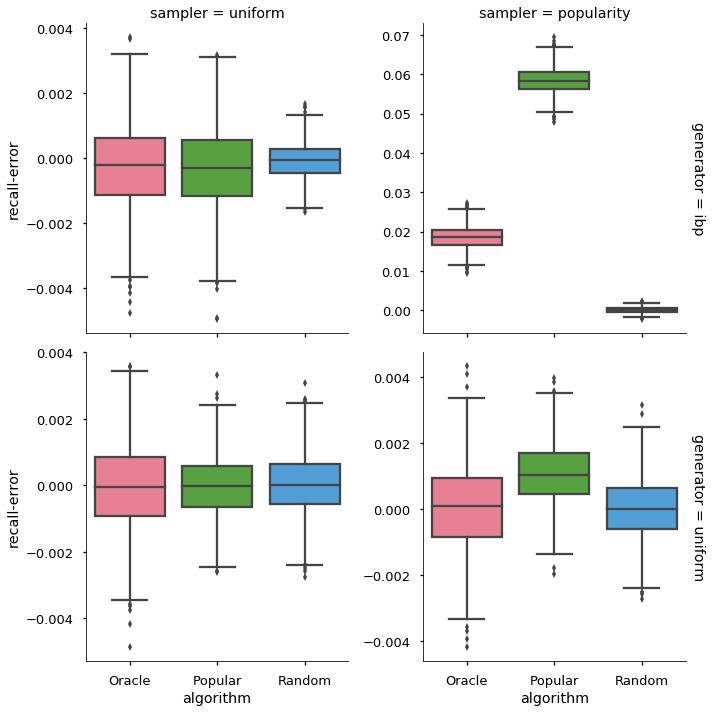

In [34]:
plot_metric_stats(data2plot, 'recall', 'error', 
                  sns.boxplot, order=['Oracle', 'Popular', 'Random'],
                  palette='husl')

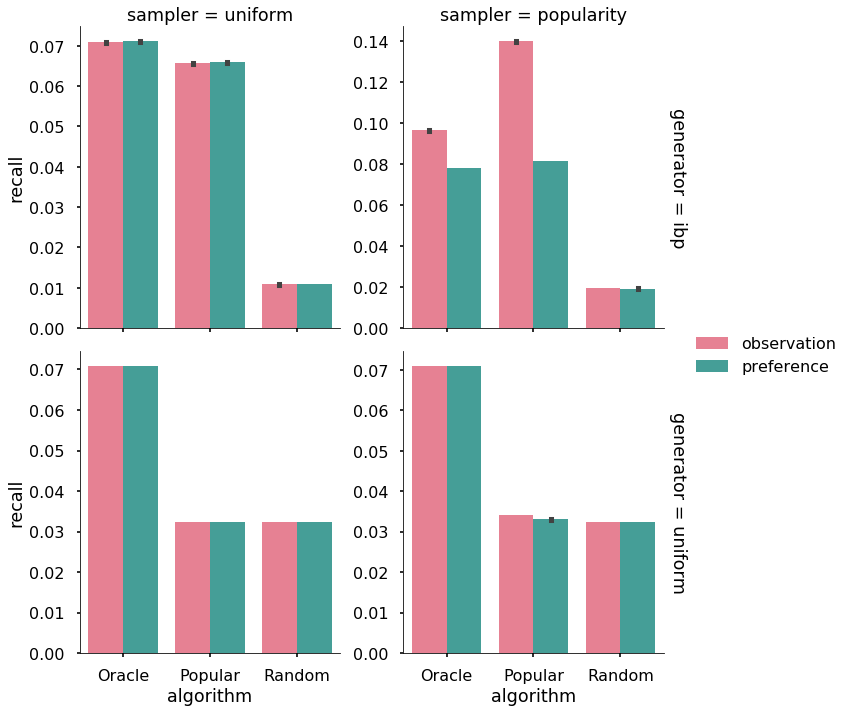

In [35]:
plot_metric_stats_dtype(data2plot, 'recall', sns.barplot, 
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=['observation', 'preference'],
                        palette='husl')

**MRR**

In [36]:
data2plot = combine_data(sims_results, g_names, s_names, 'recip_rank')

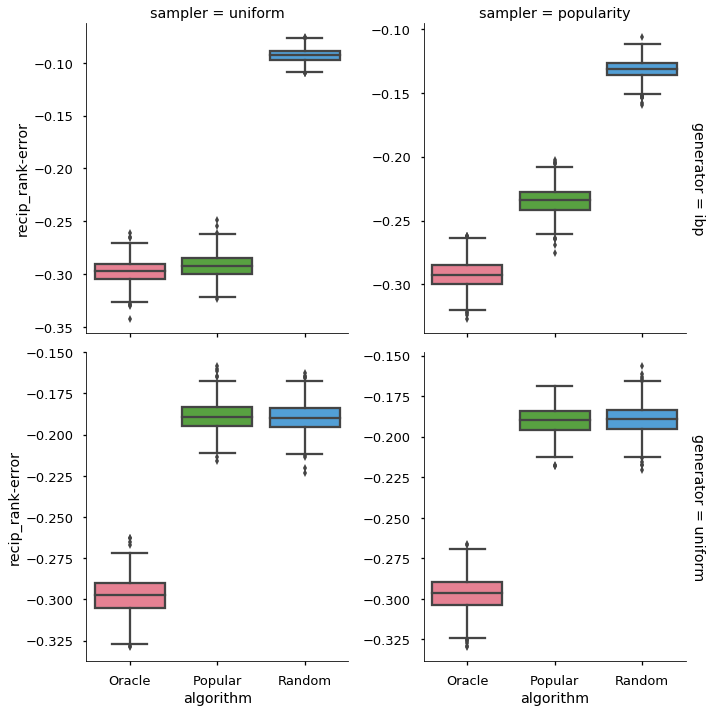

In [37]:
plot_metric_stats(data2plot, 'recip_rank', 'error', 
                  sns.boxplot, order=['Oracle', 'Popular', 'Random'],
                  palette='husl')

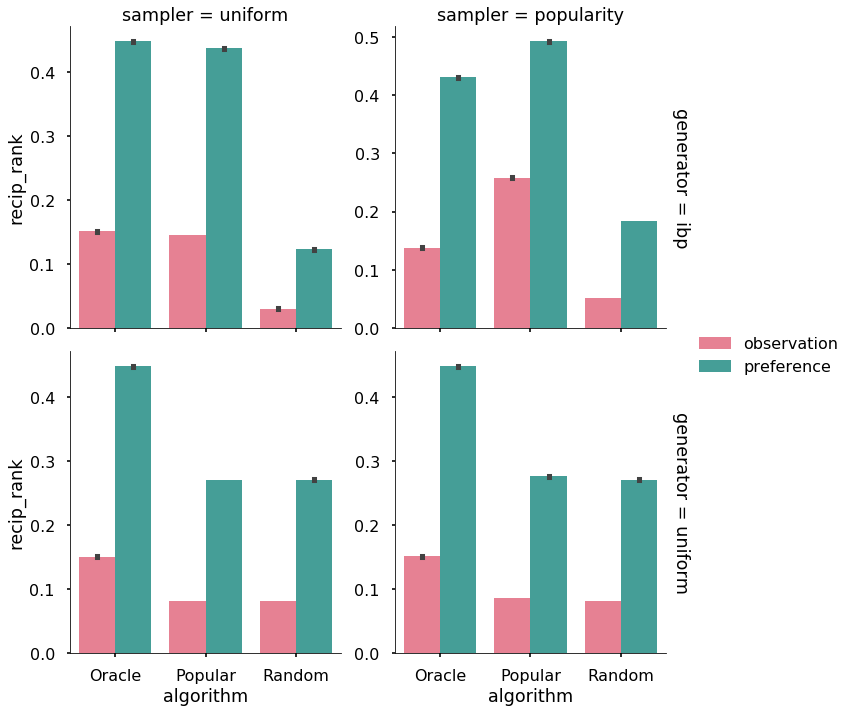

In [38]:
plot_metric_stats_dtype(data2plot, 'recip_rank', sns.barplot, 
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=['observation', 'preference'],
                        palette='husl')

**ndcg**

In [39]:
data2plot = combine_data(sims_results, g_names, s_names, 'ndcg')

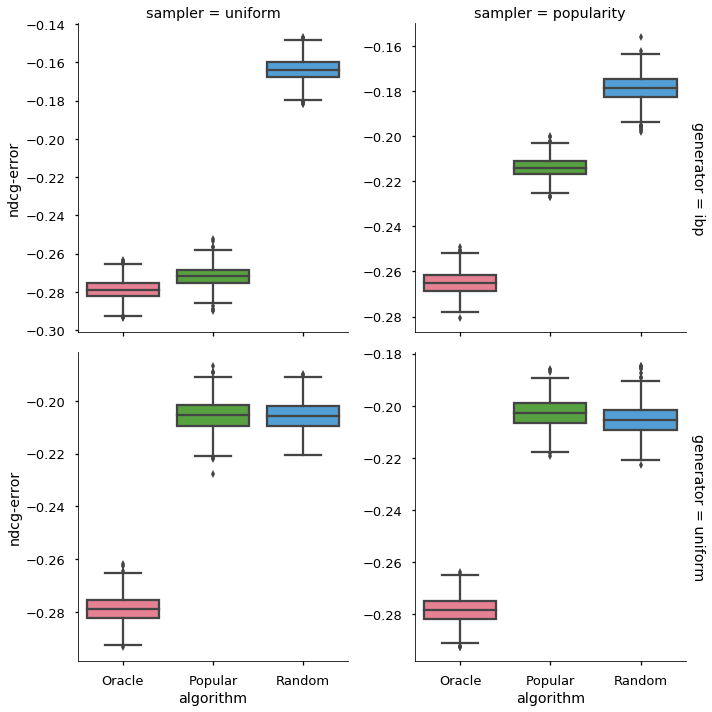

In [40]:
plot_metric_stats(data2plot, 'ndcg', 'error', 
                  sns.boxplot, order=['Oracle', 'Popular', 'Random'],
                  palette='husl')

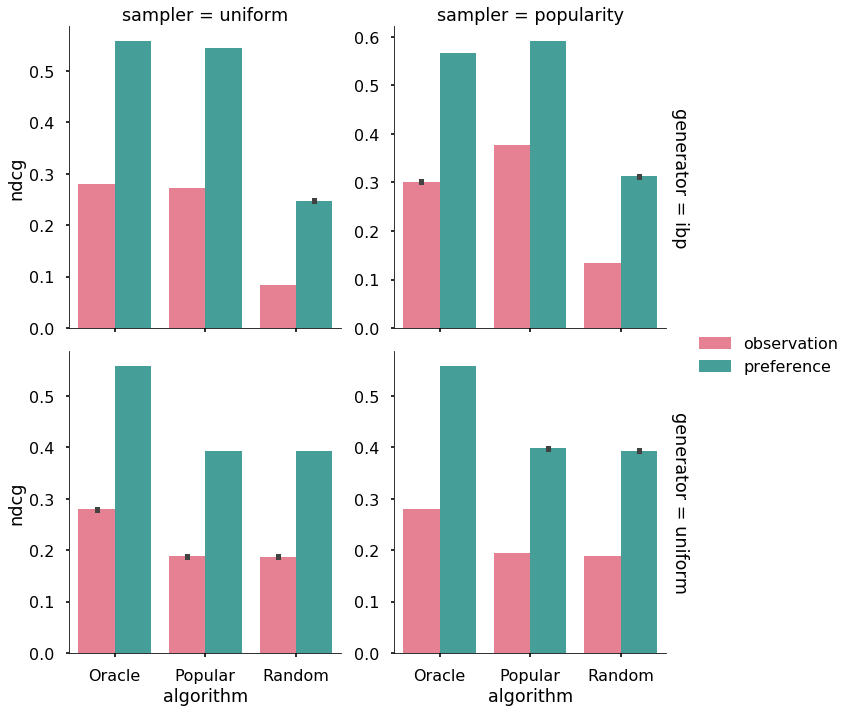

In [41]:
plot_metric_stats_dtype(data2plot, 'ndcg', sns.barplot, 
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=['observation', 'preference'],
                        palette='husl')